=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8724    0.7234    0.7910      4017
           1     0.7261    0.8739    0.7932      3370

    accuracy                         0.7921      7387
   macro avg     0.7992    0.7987    0.7921      7387
weighted avg     0.8057    0.7921    0.7920      7387

=== Confusion Matrix ===
[[2906 1111]
 [ 425 2945]]
✅ Model saved to ./features_csvs/random_forest_model.pkl

Top 20 Feature Importances:


,importance
duration,0.171192
SMA,0.131505
accelY_filtered_energy,0.075692
accelX_filtered_energy,0.057279
accelZ_filtered_energy,0.054813
accelX_filtered_deriv_mean,0.041377
accelY_filtered_mean,0.040790
accelZ_filtered_deriv_mean,0.039688
accelY_filtered_deriv_mean,0.036858
accelZ_filtered_mean,0.035483


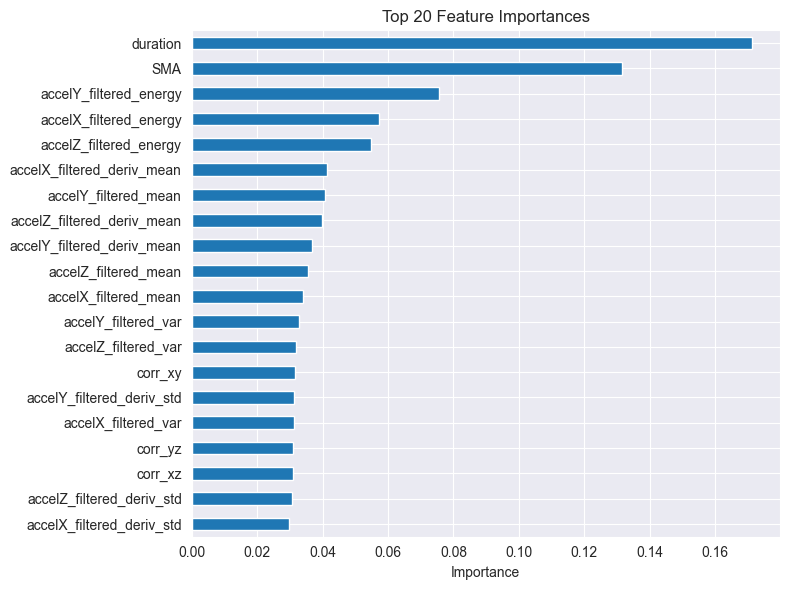

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# ─── 1. Load features dataset ────────────────────────────────────────────────
df = pd.read_csv('./features_csvs/features_dataset.csv')
X = df.drop(columns=['modality','video_id','segment','participant','label'])
y = df['label']

# ─── 2. Train/Test split ─────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ─── 3. Train Random Forest ─────────────────────────────────────────────────
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ─── 4. Evaluate ─────────────────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# ─── 5. Save model ───────────────────────────────────────────────────────────
model_path = 'pkls/ml/random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"✅ Model saved to {model_path}")

# ─── 6. Feature Importances ─────────────────────────────────────────────────
# Compute importances
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Display top 20
print("\nTop 20 Feature Importances:")
display(feat_importances_sorted.head(20).to_frame(name='importance'))

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [2]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Use the same RandomForest params as before
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute F1 (macro) across folds
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
print("5-Fold F1 scores:", np.round(f1_scores, 4))
print("Mean F1:", np.round(f1_scores.mean(),4), "±", np.round(f1_scores.std(),4))


5-Fold F1 scores: [0.7865 0.7843 0.7877 0.7892 0.7875]
Mean F1: 0.787 ± 0.0016


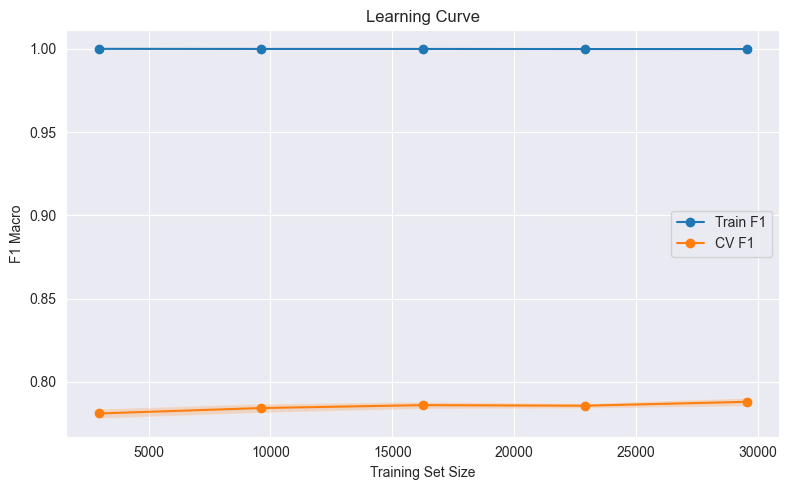

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    clf, X, y,
    cv=cv,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Compute means & stds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train F1')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, 'o-', label='CV F1')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Split once for baseline comparison
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Majority‐class predictor
major_clf = DummyClassifier(strategy='most_frequent')
major_clf.fit(X_tr, y_tr)
y_pred_maj = major_clf.predict(X_te)

# Random (uniform) predictor
rand_clf = DummyClassifier(strategy='uniform', random_state=42)
rand_clf.fit(X_tr, y_tr)
y_pred_rand = rand_clf.predict(X_te)

# Evaluate
for name, y_pred in [("Majority", y_pred_maj), ("Random", y_pred_rand)]:
    print(f"--- {name} Baseline ---")
    print("Accuracy:", accuracy_score(y_te, y_pred).round(4))
    print("F1 Macro:", f1_score(y_te, y_pred, average='macro').round(4))
    print()


--- Majority Baseline ---
Accuracy: 0.5438
F1 Macro: 0.3522

--- Random Baseline ---
Accuracy: 0.4983
F1 Macro: 0.4972



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8751    0.7598    0.8134      1153
           1     0.7445    0.8659    0.8006       932

    accuracy                         0.8072      2085
   macro avg     0.8098    0.8128    0.8070      2085
weighted avg     0.8167    0.8072    0.8077      2085

=== Confusion Matrix ===
[[876 277]
 [125 807]]
✅ Model saved to ./features_csvs/random_forest_model.pkl

Top 20 Feature Importances:


,importance
duration,0.188571
SMA,0.124358
accelY_filtered_energy,0.075310
accelX_filtered_energy,0.057492
accelZ_filtered_energy,0.054623
accelY_filtered_deriv_mean,0.043137
accelX_filtered_deriv_mean,0.040940
accelZ_filtered_deriv_mean,0.038731
accelY_filtered_mean,0.037723
accelX_filtered_mean,0.035006


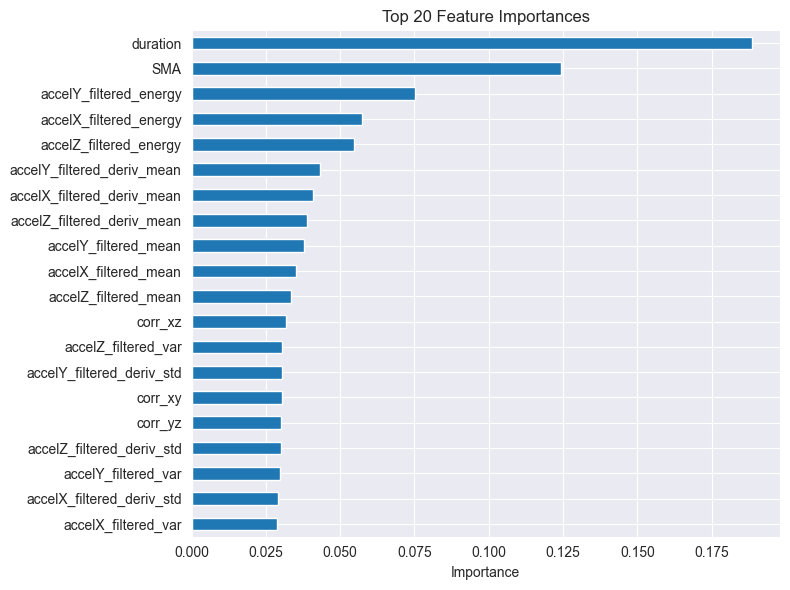

In [6]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# ─── 1. Load features dataset ────────────────────────────────────────────────
df = pd.read_csv('./features_csvs/features_dataset_with_audio.csv')
X = df.drop(columns=['modality','video_id','segment','participant','label'])
y = df['label']

# ─── 2. Train/Test split ─────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ─── 3. Train Random Forest ─────────────────────────────────────────────────
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ─── 4. Evaluate ─────────────────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# ─── 5. Save model ───────────────────────────────────────────────────────────
model_path = 'pkls/ml/random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"✅ Model saved to {model_path}")

# ─── 6. Feature Importances ─────────────────────────────────────────────────
# Compute importances
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Display top 20
print("\nTop 20 Feature Importances:")
display(feat_importances_sorted.head(20).to_frame(name='importance'))

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8341    0.7159    0.7705      1517
           1     0.7170    0.8349    0.7715      1308

    accuracy                         0.7710      2825
   macro avg     0.7756    0.7754    0.7710      2825
weighted avg     0.7799    0.7710    0.7709      2825

=== Confusion Matrix ===
[[1086  431]
 [ 216 1092]]
✅ Model saved to ./features_csvs/random_forest_model.pkl

Top 20 Feature Importances:


,importance
duration,0.179209
SMA,0.120804
accelY_filtered_energy,0.076754
accelX_filtered_energy,0.055560
accelZ_filtered_energy,0.055282
accelZ_filtered_deriv_mean,0.043200
accelX_filtered_mean,0.039080
accelY_filtered_deriv_mean,0.038228
accelX_filtered_deriv_mean,0.037756
accelY_filtered_mean,0.037744


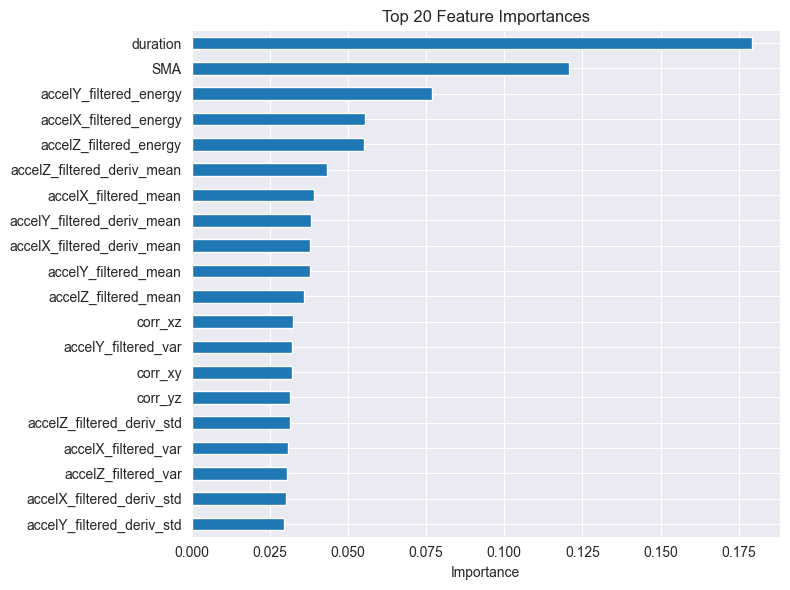

In [7]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# ─── 1. Load features dataset ────────────────────────────────────────────────
df = pd.read_csv('./features_csvs/features_dataset_wa_na.csv')
X = df.drop(columns=['modality','video_id','segment','participant','label'])
y = df['label']

# ─── 2. Train/Test split ─────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ─── 3. Train Random Forest ─────────────────────────────────────────────────
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ─── 4. Evaluate ─────────────────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# ─── 5. Save model ───────────────────────────────────────────────────────────
model_path = 'pkls/ml/random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"✅ Model saved to {model_path}")

# ─── 6. Feature Importances ─────────────────────────────────────────────────
# Compute importances
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Display top 20
print("\nTop 20 Feature Importances:")
display(feat_importances_sorted.head(20).to_frame(name='importance'))

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8699    0.7222    0.7892      4017
           1     0.7246    0.8712    0.7912      3370

    accuracy                         0.7902      7387
   macro avg     0.7972    0.7967    0.7902      7387
weighted avg     0.8036    0.7902    0.7901      7387

=== Confusion Matrix ===
[[2901 1116]
 [ 434 2936]]
✅ Model saved to ./features_csvs/random_forest_model_without_duration.pkl

Top 20 Feature Importances:


,importance
SMA,0.154102
accelX_filtered_energy,0.099387
accelY_filtered_energy,0.093903
accelZ_filtered_energy,0.073295
accelZ_filtered_deriv_mean,0.049002
accelX_filtered_deriv_mean,0.048971
accelY_filtered_deriv_mean,0.044857
accelZ_filtered_mean,0.040533
accelX_filtered_mean,0.040141
accelX_filtered_var,0.038796


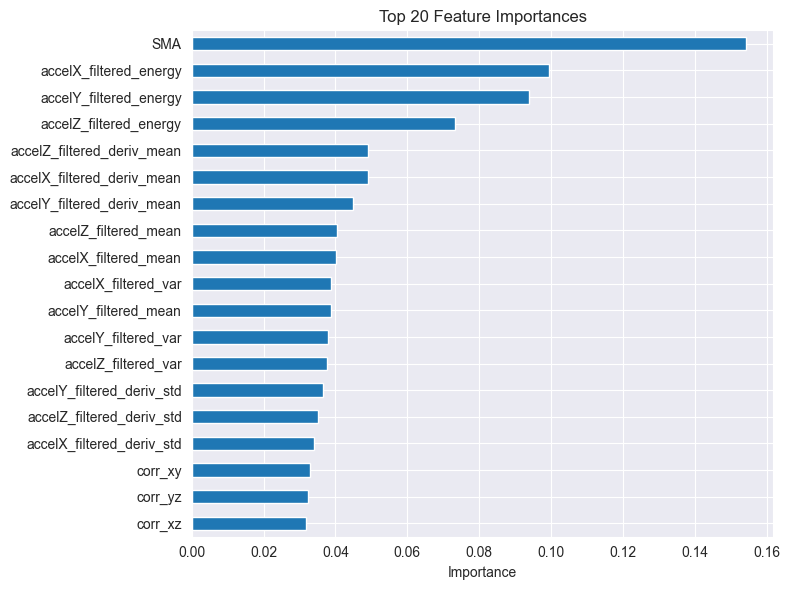

In [8]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# ─── 1. Load features dataset ────────────────────────────────────────────────
df = pd.read_csv('./features_csvs/features_dataset_without_duration.csv')
X = df.drop(columns=['modality','video_id','segment','participant','label'])
y = df['label']

# ─── 2. Train/Test split ─────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ─── 3. Train Random Forest ─────────────────────────────────────────────────
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ─── 4. Evaluate ─────────────────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# ─── 5. Save model ───────────────────────────────────────────────────────────
model_path = 'pkls/ml/random_forest_model_without_duration.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"✅ Model saved to {model_path}")

# ─── 6. Feature Importances ─────────────────────────────────────────────────
# Compute importances
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Display top 20
print("\nTop 20 Feature Importances:")
display(feat_importances_sorted.head(20).to_frame(name='importance'))

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [13]:
import os
import re
import pandas as pd
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"    # directory with your feature CSVs
random_state = 42

# ─── 1) Discover all per-window feature CSVs ────────────────────────────────
# Match any file ending in "_<number>s.csv"
feat_files = [
    f for f in glob(os.path.join(features_dir, "features_segments_with_audio_*s.csv"))
    if re.search(r"_(\d+)s\.csv$", f)
]
if not feat_files:
    raise RuntimeError(f"No feature CSVs found in {features_dir}")

# ─── 2) Evaluate each feature set ───────────────────────────────────────────
results = []

for feat_path in sorted(feat_files):
    # Extract window size (e.g. 5 from "..._5s.csv")
    m = re.search(r"_(\d+)s\.csv$", feat_path)
    window_s = int(m.group(1)) if m else None

    # Load features
    df = pd.read_csv(feat_path)
    X = df.drop(columns=["video_id","segment","participant","window_i","window_s","label"])
    y = df["label"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)

    # Predict & compute metrics
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred, zero_division=0)
    f1        = f1_score(y_test, y_pred, zero_division=0)
    acc       = accuracy_score(y_test, y_pred)

    # 5-fold cross-validated F1-macro
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')

    # Store results
    results.append({
        "window_s":   window_s,
        "n_samples":  len(df),
        "precision":  precision,
        "recall":     recall,
        "f1_macro":   f1,
        "accuracy":   acc,
        "cv_f1_mean": cv_scores.mean(),
        "cv_f1_std":  cv_scores.std()
    })

    print(f"\n▶ Window {window_s}s:\n"
          f"  Precision: {precision:.3f}, Recall: {recall:.3f}, "
          f"F1-macro: {f1:.3f}, Accuracy: {acc:.3f}\n"
          f"  5-fold CV F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ─── 3) Summary ────────────────────────────────────────────────────────────
summary_df = pd.DataFrame(results).sort_values("window_s")
print("\nSummary of fixed-window evaluations:")
print(summary_df)



▶ Window 10s:
  Precision: 0.200, Recall: 0.006, F1-macro: 0.011, Accuracy: 0.859
  5-fold CV F1-macro: 0.471 ± 0.002

▶ Window 1s:
  Precision: 0.000, Recall: 0.000, F1-macro: 0.000, Accuracy: 0.949
  5-fold CV F1-macro: 0.487 ± 0.000

▶ Window 20s:
  Precision: 0.356, Recall: 0.045, F1-macro: 0.081, Accuracy: 0.781
  5-fold CV F1-macro: 0.483 ± 0.009

▶ Window 5s:
  Precision: 0.300, Recall: 0.002, F1-macro: 0.005, Accuracy: 0.905
  5-fold CV F1-macro: 0.477 ± 0.001

Summary of fixed-window evaluations:
   window_s  n_samples  precision    recall  f1_macro  accuracy  cv_f1_mean  \
1         1     313488   0.000000  0.000000  0.000000  0.948946    0.486904   
3         5      63312   0.300000  0.002490  0.004938  0.904525    0.476722   
0        10      32016   0.200000  0.005618  0.010929  0.858682    0.471310   
2        20      16128   0.356322  0.045388  0.080519  0.780533    0.482728   

   cv_f1_std  
1   0.000002  
3   0.000578  
0   0.002228  
2   0.008630  


In [21]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"
feat_file    = os.path.join(features_dir, "features_segments_with_audio_1s.csv")
random_state = 42

# ─── 1) Load the 1 s window feature set ─────────────────────────────────────
df = pd.read_csv(feat_file)
X  = df.drop(columns=["video_id","segment","participant","window_i","window_s","label"])
y  = df["label"]

# ─── 2) Train/test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=random_state
)

# ─── 3) Train Random Forest with class balancing ───────────────────────────
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=random_state
)
clf.fit(X_train, y_train)

# ─── 4) Evaluate on hold-out test set ──────────────────────────────────────
y_pred = clf.predict(X_test)
print("Classification Report (1 s windows):")
print(classification_report(y_test, y_pred, zero_division=0))

prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")

# ─── 5) 5-Fold cross-validation (F1-macro) ──────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
print(f"5-Fold CV F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Classification Report (1 s windows):
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     24416
           1       0.09      0.39      0.14      1783

    accuracy                           0.67     26199
   macro avg       0.51      0.54      0.47     26199
weighted avg       0.88      0.67      0.75     26199

Precision: 0.086, Recall: 0.394, F1-score: 0.141
5-Fold CV F1-macro: 0.474 ± 0.002



Top 20 Feature Importances:


,importance
corr_yz,0.059572
corr_xy,0.058055
accelX_filtered_mean,0.057096
accelZ_filtered_deriv_std,0.056718
corr_xz,0.055500
accelX_filtered_deriv_std,0.055444
accelX_filtered_deriv_mean,0.055056
accelZ_filtered_mean,0.054355
accelZ_filtered_deriv_mean,0.054164
accelY_filtered_deriv_mean,0.053871


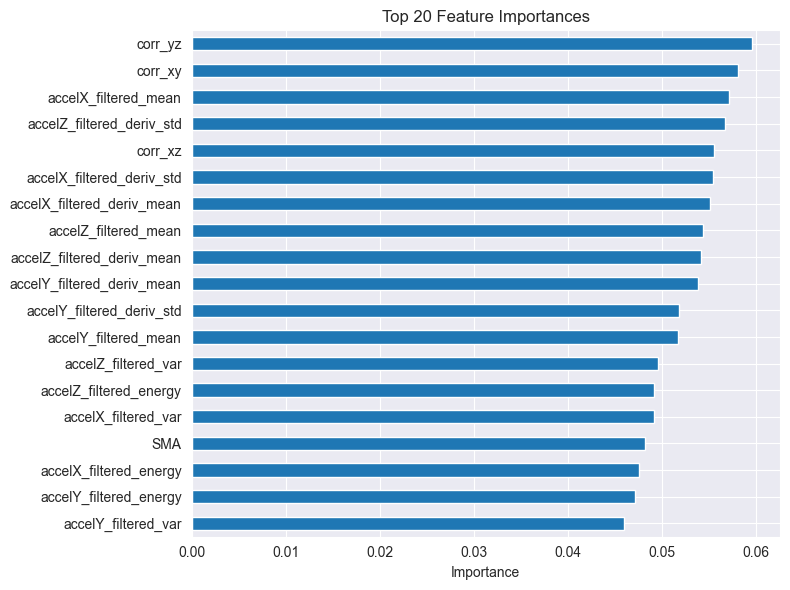

In [23]:
# ─── 6. Feature Importances ─────────────────────────────────────────────────
# Compute importances
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# Display top 20
print("\nTop 20 Feature Importances:")
display(feat_importances_sorted.head(20).to_frame(name='importance'))

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [4]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"
feat_file    = os.path.join(features_dir, "features_fixed_10s.csv")
random_state = 42

# ─── 1) Carga del DataFrame y chequeo de columnas ──────────────────────────
df = pd.read_csv(feat_file)
print("COLUMNAS DISPONIBLES:", df.columns.tolist())
print(df.head(2))

# … tras leer df …
# detectamos automáticamente columnas problemáticas:
leak_cols = [c for c in df.columns if c in ("label","run_count","n_laugh_runs","n_laughed")]
print("Columnas a eliminar por filtración:", leak_cols)

# Eliminamos también las metadatos
meta = ["modality","video_id","segment","participant","window_i","window_s","start_s","end_s"]
drop_cols = [c for c in leak_cols + meta if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["label"]

print("Features finales:", X.columns.tolist())
# … resto del entrenamiento como antes …


print("\nCOLUMNAS EN X TRAS EL DROP:", X.columns.tolist())

# ─── 3) Train/test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

# ─── 4) Entrena Random Forest ───────────────────────────────────────────────
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=random_state
)
clf.fit(X_train, y_train)

# ─── 5) Evalúa en el conjunto de test ───────────────────────────────────────
y_pred = clf.predict(X_test)
print("\nClassification Report (ventanas fijas):")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}, "
      f"Recall: {recall_score(y_test, y_pred, zero_division=0):.3f}, "
      f"F1-score: {f1_score(y_test, y_pred, zero_division=0):.3f}")

# ─── 6) 5-Fold Cross-Validation ──────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
print(f"5-Fold CV F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


COLUMNAS DISPONIBLES: ['accelX_filtered_mean', 'accelX_filtered_var', 'accelX_filtered_energy', 'accelY_filtered_mean', 'accelY_filtered_var', 'accelY_filtered_energy', 'accelZ_filtered_mean', 'accelZ_filtered_var', 'accelZ_filtered_energy', 'accelX_filtered_deriv_mean', 'accelX_filtered_deriv_std', 'accelY_filtered_deriv_mean', 'accelY_filtered_deriv_std', 'accelZ_filtered_deriv_mean', 'accelZ_filtered_deriv_std', 'SMA', 'corr_xy', 'corr_xz', 'corr_yz', 'modality', 'video_id', 'segment', 'participant', 'start_s', 'end_s', 'run_count', 'label']
   accelX_filtered_mean  accelX_filtered_var  accelX_filtered_energy  \
0             -0.024783             0.861594              387.993913   
1              0.006695             0.321787              144.824380   

   accelY_filtered_mean  accelY_filtered_var  accelY_filtered_energy  \
0              0.001649             1.614814              726.667466   
1             -0.023745             0.409242              184.412430   

   accelZ_filte

In [5]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"
feat_file    = os.path.join(features_dir, "features_fixed_1s.csv")
random_state = 42

# ─── 1) Carga del DataFrame y chequeo de columnas ──────────────────────────
df = pd.read_csv(feat_file)
print("COLUMNAS DISPONIBLES:", df.columns.tolist())
print(df.head(2))

# … tras leer df …
# detectamos automáticamente columnas problemáticas:
leak_cols = [c for c in df.columns if c in ("label","run_count","n_laugh_runs","n_laughed")]
print("Columnas a eliminar por filtración:", leak_cols)

# Eliminamos también las metadatos
meta = ["modality","video_id","segment","participant","window_i","window_s","start_s","end_s"]
drop_cols = [c for c in leak_cols + meta if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["label"]

print("Features finales:", X.columns.tolist())
# … resto del entrenamiento como antes …


print("\nCOLUMNAS EN X TRAS EL DROP:", X.columns.tolist())

# ─── 3) Train/test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

# ─── 4) Entrena Random Forest ───────────────────────────────────────────────
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=random_state
)
clf.fit(X_train, y_train)

# ─── 5) Evalúa en el conjunto de test ───────────────────────────────────────
y_pred = clf.predict(X_test)
print("\nClassification Report (ventanas fijas):")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}, "
      f"Recall: {recall_score(y_test, y_pred, zero_division=0):.3f}, "
      f"F1-score: {f1_score(y_test, y_pred, zero_division=0):.3f}")

# ─── 6) 5-Fold Cross-Validation ──────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
print(f"5-Fold CV F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


COLUMNAS DISPONIBLES: ['accelX_filtered_mean', 'accelX_filtered_var', 'accelX_filtered_energy', 'accelY_filtered_mean', 'accelY_filtered_var', 'accelY_filtered_energy', 'accelZ_filtered_mean', 'accelZ_filtered_var', 'accelZ_filtered_energy', 'accelX_filtered_deriv_mean', 'accelX_filtered_deriv_std', 'accelY_filtered_deriv_mean', 'accelY_filtered_deriv_std', 'accelZ_filtered_deriv_mean', 'accelZ_filtered_deriv_std', 'SMA', 'corr_xy', 'corr_xz', 'corr_yz', 'modality', 'video_id', 'segment', 'participant', 'start_s', 'end_s', 'run_count', 'label']
   accelX_filtered_mean  accelX_filtered_var  accelX_filtered_energy  \
0             -0.149865             0.149814                4.823660   
1             -0.144995             0.188085                5.855035   

   accelY_filtered_mean  accelY_filtered_var  accelY_filtered_energy  \
0             -0.002381             0.120804                3.382680   
1              0.002993             0.241834                6.771591   

   accelZ_filte

KeyboardInterrupt: 

In [7]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Carga tu dataset
df = pd.read_csv(feat_file)
#X = df.drop(columns=["video_id","segment","participant","window_i","window_s","label"])
y = df["label"]

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Undersampling de la clase mayoritaria (0) para ratio 1:1
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print("Distribución tras undersample:", Counter(y_res))

# 4. Entrena RF normal
clf_under = RandomForestClassifier(n_estimators=100, random_state=42)
clf_under.fit(X_res, y_res)

# 5. Evalúa en test
y_pred = clf_under.predict(X_test)
print("=== RF + Undersampling ===")
print(classification_report(y_test, y_pred, zero_division=0))


Distribución tras undersample: Counter({0: 71003, 1: 71003})
=== RF + Undersampling ===
              precision    recall  f1-score   support

           0       0.95      0.55      0.70    299280
           1       0.07      0.54      0.12     17751

    accuracy                           0.55    317031
   macro avg       0.51      0.55      0.41    317031
weighted avg       0.90      0.55      0.67    317031



In [9]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    precision_score, recall_score, f1_score,
    precision_recall_curve
)

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"
feat_file    = os.path.join(features_dir, "features_segments_with_audio_1s.csv")
random_state = 42

# ─── 1) Load the 1 s window feature set ─────────────────────────────────────
df = pd.read_csv(feat_file)
X  = df.drop(columns=["video_id","segment","participant","window_i","window_s","label"])
y  = df["label"]

# ─── 2) Train/test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=random_state
)

# ─── 3) Train Random Forest with balanced_subsample ─────────────────────────
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced_subsample",
    random_state=random_state
)
clf.fit(X_train, y_train)

# ─── 4) Predict probabilities on test set ───────────────────────────────────
probs = clf.predict_proba(X_test)[:,1]  # probabilidad de clase '1' (risa)

# ─── 5) Precision–Recall curve & best-threshold ────────────────────────────
prec, rec, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.argmax(f1_scores)
best_thresh = thresholds[ix]
print(f"Mejor umbral = {best_thresh:.3f}, F1 = {f1_scores[ix]:.3f}")

# ─── 6) Evaluación con el umbral óptimo ────────────────────────────────────
y_pred_thresh = (probs >= best_thresh).astype(int)
print("\nClassification Report (umbral ajustado):")
print(classification_report(y_test, y_pred_thresh, zero_division=0))

# ─── 7) 5-Fold cross-validation (F1-macro) ──────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
print(f"\n5-Fold CV F1-macro: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Mejor umbral = 0.375, F1 = 0.144

Classification Report (umbral ajustado):
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     24416
           1       0.08      0.49      0.14      1783

    accuracy                           0.61     26199
   macro avg       0.51      0.55      0.44     26199
weighted avg       0.88      0.61      0.70     26199


5-Fold CV F1-macro: 0.474 ± 0.002


In [12]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# ─── CONFIG ────────────────────────────────────────────────────────────────
features_dir = "./features_csvs"
feat_file    = os.path.join(features_dir, "features_fixed_10s.csv")
random_state = 42

# ─── 1) Carga del DataFrame y chequeo de columnas ──────────────────────────
df = pd.read_csv(feat_file)
print("COLUMNAS DISPONIBLES:", df.columns.tolist())
print(df.head(2))

# … tras leer df …
# detectamos automáticamente columnas problemáticas:
leak_cols = [c for c in df.columns if c in ("label","run_count","n_laugh_runs","n_laughed")]
print("Columnas a eliminar por filtración:", leak_cols)

# Eliminamos también las metadatos
meta = ["modality","video_id","segment","participant","window_i","window_s","start_s","end_s"]
drop_cols = [c for c in leak_cols + meta if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["label"]

print("Features finales:", X.columns.tolist())
# … resto del entrenamiento como antes …


print("\nCOLUMNAS EN X TRAS EL DROP:", X.columns.tolist())

# ─── 1) Config ──────────────────────────────────────────────────────────────
T = 10  # número de ventanas por secuencia
feature_cols = [c for c in X.columns]  # tus columnas de features
# suponemos que X, y y df tienen columnas video_id, segment, participant, window_i

# ─── 2) Construir secuencias de largo T ────────────────────────────────────
seqs = []
lengths = []
seq_labels = []  # opcional, si quieres etiquetar secuencia completa

# iteramos por cada (video,segment,participant) natural
for key, grp in df.groupby(["video_id","segment","participant"]):
    grp = grp.sort_values("window_i")
    feats = grp[feature_cols].values
    labs  = grp["label"].values  # 0/1 por ventana

    n_chunks = len(feats) // T
    for i in range(n_chunks):
        chunk_feats = feats[i*T:(i+1)*T]
        chunk_labs  = labs[i*T:(i+1)*T]

        seqs.append(chunk_feats)
        lengths.append(T)
        # definimos la etiqueta de toda la secuencia;
        # p.ej. 1 si aparece al menos una risa
        seq_labels.append(int(chunk_labs.sum() > 0))

# Ahora apilamos
X_seqs = np.vstack(seqs)           # shape = (n_chunks * T, n_feats)
lengths = np.array(lengths)        # lista de longitudes (= T cada una)
y_seqs = np.array(seq_labels)      # etiqueta de cada secuencia

# ─── 3) Ajustar el HMM ─────────────────────────────────────────────────────
model = GaussianHMM(
    n_components=2,        # dos estados: “no risa” / “risa”
    covariance_type="diag",
    n_iter=100,
    random_state=42
)
model.fit(X_seqs, lengths=lengths)

# ─── 4) Inferir estado en cada secuencia ───────────────────────────────────
pred_states = []
idx = 0
for L in lengths:
    seq = X_seqs[idx:idx+L]
    states = model.predict(seq)  # tamaño L, valores 0/1
    pred_states.append(states)
    idx += L

# Si quieres resumir cada secuencia:
seq_pred_labels = [int(s.sum()>0) for s in pred_states]  # 1 si hubo algún estado “1”

# ─── 5) Evaluación ────────────────────────────────────────────────────────
from sklearn.metrics import classification_report
print(classification_report(y_seqs, seq_pred_labels))


              precision    recall  f1-score   support

           0       0.77      0.22      0.34      9662
           1       0.25      0.80      0.38      3154

    accuracy                           0.36     12816
   macro avg       0.51      0.51      0.36     12816
weighted avg       0.64      0.36      0.35     12816



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from hmmlearn.hmm import GaussianHMM

# ─── 1) Carga tu CSV de características de 10 s ───────────────────────────────
feat_file = "./features_csvs/features_segments_with_audio_10s.csv"
df       = pd.read_csv(feat_file)

# columnas que no son features
drop_cols = ["video_id","segment","participant","window_i","window_s","label"]
feature_cols = [c for c in df.columns if c not in drop_cols]

# ─── 2) Agrupa en secuencias de T=10 ventanas de 10 s ────────────────────────
T = 10
seqs, lengths, seq_labels = [], [], []
for _, grp in df.groupby(["video_id","segment","participant"]):
    grp = grp.sort_values("window_i")
    feats = grp[feature_cols].values
    labs  = grp["label"].values
    n_chunks = len(feats) // T
    for i in range(n_chunks):
        seqs.append(feats[i*T:(i+1)*T])
        lengths.append(T)
        seq_labels.append(int(labs[i*T:(i+1)*T].sum() > 0))

n_seqs = len(seqs)
y_seqs = np.array(seq_labels)

# ─── 3) Split por secuencia (no por fila) ──────────────────────────────────
seq_ids = np.arange(n_seqs)
train_ids, val_ids = train_test_split(
    seq_ids, test_size=0.2,
    stratify=y_seqs, random_state=42
)

# Reconstruye X_tr, len_tr, y_tr, y_val...
def stack_by_ids(ids):
    X_list, L_list, Y_list = [], [], []
    for idx in ids:
        X_list.append(seqs[idx])
        L_list.append(lengths[idx])
        Y_list.append(y_seqs[idx])
    return np.vstack(X_list), np.array(L_list), np.array(Y_list)

X_tr, len_tr, y_tr = stack_by_ids(train_ids)
X_val, len_val, y_val = stack_by_ids(val_ids)

# ─── 4) Entrena el HMM ─────────────────────────────────────────────────────
model = GaussianHMM(n_components=2, covariance_type="diag",
                    n_iter=100, random_state=42)
model.fit(X_tr, lengths=len_tr)

# ─── 5) Predice estados en validación ─────────────────────────────────────
states_val = []
idx = 0
for L in len_val:
    st = model.predict(X_val[idx:idx+L])
    states_val.append(st)
    idx += L

# ─── 6) Ajusta umbral α sobre la proporción de estado “1” ─────────────────
prop1 = np.array([s.sum()/len(s) for s in states_val])
best_f1, best_alpha = 0, 0.0
for alpha in np.linspace(0,1,51):
    y_hat = (prop1 >= alpha).astype(int)
    f1 = f1_score(y_val, y_hat, average="macro")
    if f1 > best_f1:
        best_f1, best_alpha = f1, alpha

print(f"✅ [10 s] Mejor α = {best_alpha:.2f}, F1-macro = {best_f1:.3f}")

# ─── 7) Reporte final ──────────────────────────────────────────────────────
y_pred = (prop1 >= best_alpha).astype(int)
print(classification_report(y_val, y_pred, zero_division=0))


✅ [10 s] Mejor α = 0.12, F1-macro = 0.519
              precision    recall  f1-score   support

           0       0.50      0.40      0.44       277
           1       0.55      0.65      0.59       309

    accuracy                           0.53       586
   macro avg       0.53      0.52      0.52       586
weighted avg       0.53      0.53      0.52       586



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from hmmlearn.hmm import GaussianHMM

# ─── 1) Carga tu CSV de características de 10 s ───────────────────────────────
feat_file = "./features_csvs/features_segments_with_audio_1s.csv"
df       = pd.read_csv(feat_file)

# columnas que no son features
drop_cols = ["video_id","segment","participant","window_i","window_s","label"]
feature_cols = [c for c in df.columns if c not in drop_cols]

# ─── 2) Agrupa en secuencias de T=10 ventanas de 10 s ────────────────────────
T = 10
seqs, lengths, seq_labels = [], [], []
for _, grp in df.groupby(["video_id","segment","participant"]):
    grp = grp.sort_values("window_i")
    feats = grp[feature_cols].values
    labs  = grp["label"].values
    n_chunks = len(feats) // T
    for i in range(n_chunks):
        seqs.append(feats[i*T:(i+1)*T])
        lengths.append(T)
        seq_labels.append(int(labs[i*T:(i+1)*T].sum() > 0))

n_seqs = len(seqs)
y_seqs = np.array(seq_labels)

# ─── 3) Split por secuencia (no por fila) ──────────────────────────────────
seq_ids = np.arange(n_seqs)
train_ids, val_ids = train_test_split(
    seq_ids, test_size=0.2,
    stratify=y_seqs, random_state=42
)

# Reconstruye X_tr, len_tr, y_tr, y_val...
def stack_by_ids(ids):
    X_list, L_list, Y_list = [], [], []
    for idx in ids:
        X_list.append(seqs[idx])
        L_list.append(lengths[idx])
        Y_list.append(y_seqs[idx])
    return np.vstack(X_list), np.array(L_list), np.array(Y_list)

X_tr, len_tr, y_tr = stack_by_ids(train_ids)
X_val, len_val, y_val = stack_by_ids(val_ids)

# ─── 4) Entrena el HMM ─────────────────────────────────────────────────────
model = GaussianHMM(n_components=2, covariance_type="diag",
                    n_iter=100, random_state=42)
model.fit(X_tr, lengths=len_tr)

# ─── 5) Predice estados en validación ─────────────────────────────────────
states_val = []
idx = 0
for L in len_val:
    st = model.predict(X_val[idx:idx+L])
    states_val.append(st)
    idx += L

# ─── 6) Ajusta umbral α sobre la proporción de estado “1” ─────────────────
prop1 = np.array([s.sum()/len(s) for s in states_val])
best_f1, best_alpha = 0, 0.0
for alpha in np.linspace(0,1,51):
    y_hat = (prop1 >= alpha).astype(int)
    f1 = f1_score(y_val, y_hat, average="macro")
    if f1 > best_f1:
        best_f1, best_alpha = f1, alpha

print(f"✅ [1 s] Mejor α = {best_alpha:.2f}, F1-macro = {best_f1:.3f}")

# ─── 7) Reporte final ──────────────────────────────────────────────────────
y_pred = (prop1 >= best_alpha).astype(int)
print(classification_report(y_val, y_pred, zero_division=0))


✅ [1 s] Mejor α = 0.70, F1-macro = 0.501
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1933
           1       0.25      0.25      0.25       631

    accuracy                           0.63      2564
   macro avg       0.50      0.50      0.50      2564
weighted avg       0.63      0.63      0.63      2564

